In [118]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt, colors as mcolors

import os
import shutil
import numpy as np
from scipy import signal

import plotly.express as px

COLORS = [color[0] for color in list(mcolors.TABLEAU_COLORS.items())]

In [276]:
def plott(dfs, columns, labels=None, x='Number of env steps total', smooth=True, kind='line', agg=None):
    assert kind in ['line', 'bar']
    if labels is not None:
        assert len(dfs) == len(labels)
        
    if type(agg) is not list:
        agg = [agg] * len(dfs)

    if len(columns) > 2:
        fig, axs = plt.subplots(2,2)
        fig.set_figheight(10)
        fig.set_figwidth(15)
    else:
        fig, axs = plt.subplots(1,2)
        fig.set_figheight(5)
        fig.set_figwidth(15)

    for i, column in enumerate(columns):    
        for j, df in enumerate(dfs):
            if column not in df.columns:
                continue
            if len(columns) > 2:
                axspos = axs[int(i/2), int(i%2)]
            else:
                axspos = axs[i]

            if kind == 'line':
                if smooth:
                    axspos.plot(df[x], signal.savgol_filter(df[column], 51, 11), figure=fig, color=COLORS[j], label=labels[j])
                axspos.plot(df[x], df[column], figure=fig, alpha=0.2 if smooth else 1, color=COLORS[j], label=None if smooth else labels[j])
            else:
                axspos.bar(j, df[x].mean() if agg[i] is None or agg[i] == 'mean' else df[x].max() / 3600, figure=fig, color=COLORS[j], label=labels[j])
            axspos.legend(loc='upper right')
            axspos.set_title(column)

In [152]:
REMOVE_BELOW_STEPS = 100000
progresses = []

for dirname, _, filenames in os.walk('output'):
    for filename in filenames:
        if 'progress' in filename:
            file = os.path.join(dirname, filename)

            try:
                tempdf = pd.read_csv(file)
            except pd.errors.EmptyDataError as e:
                shutil.rmtree(dirname, ignore_errors=True)
                print('Removed empty folder', dirname)
                continue

            steps = tempdf['Number of env steps total'].iloc[-1]
            if steps < REMOVE_BELOW_STEPS:
                # shutil.rmtree(dirname, ignore_errors=True)
                print('Removed small experiment (', steps, ' steps)', dirname)
                continue
                
            progresses.append(file)

progresses.sort()
for i, progress in enumerate(progresses):
    print(i, progress)

0 output/cheetah-vel/2020_02_16_00_49_55/progress.csv
1 output/cheetah-vel/2020_02_17_18_09_55/progress.csv
2 output/cheetah-vel/2020_03_03_16_20_26/progress.csv
3 output/cheetah-vel/2020_03_04_17_23_41/progress.csv
4 output/cheetah-vel/2020_03_05_23_41_01/progress.csv
5 output/cheetah-vel/2020_03_06_13_23_33/progress.csv
6 output/cheetah-vel/2020_03_07_17_09_05/progress.csv
7 output/cheetah-vel/2020_03_07_23_12_39/progress.csv
8 output/cheetah-vel/2020_03_17_00_33_59/progress.csv
9 output/pick-place-ml1/2020_02_15_02_00_11/progress.csv
10 output/pick-place-ml1/2020_02_15_02_02_24/progress.csv
11 output/pick-place-ml1/2020_03_04_01_00_28/progress.csv


In [272]:
results = [
    # ('Int. Ctx', pd.read_csv(progresses[1], skiprows=[1])),
    ('PEARL', pd.read_csv(progresses[2], skiprows=[1])),
    # ('PEARL 2', pd.read_csv(progresses[3], skiprows=[1])),
    ('Int. Obs', pd.read_csv(progresses[0], skiprows=[1])),
    ('Int. Ctx', pd.read_csv(progresses[4], skiprows=[1])),
    ('Ctx Only Grads', pd.read_csv(progresses[5], skiprows=[1])),
    #('Int. Ctx 3', pd.read_csv(progresses[6], skiprows=[1])),
    #('Int. Ctx 4', pd.read_csv(progresses[7], skiprows=[1])),
    ('L2', pd.read_csv(progresses[8], skiprows=[1])),
]

for i, (label, df) in enumerate(results):
    if label == 'PEARL' and 'Mean Intrinsic Reward' in df.columns:
        label = 'Intrinsic'
        results[i] = (label, df)
    
    hours = '%.2f' % float(df['Total Train Time (s)'].iloc[-1] / 60 / 60)
    print('Results ' + str(i) + ' (' + label + '): ', df['Number of env steps total'].iloc[-1], ' steps in ', hours, 'hours')
    
results[0][1].columns

Results 0 (PEARL):  1200000  steps in  8.55 hours
Results 1 (Int. Obs):  1380000  steps in  36.74 hours
Results 2 (Int. Ctx):  1500000  steps in  12.30 hours
Results 3 (Ctx Only Grads):  1115000  steps in  8.72 hours
Results 4 (L2):  2000000  steps in  14.93 hours


Index(['Z mean train', 'Z variance train', 'KL Divergence', 'KL Loss',
       'QF Loss', 'VF Loss', 'Policy Loss', 'Q Predictions Mean',
       'Q Predictions Std', 'Q Predictions Max', 'Q Predictions Min',
       'V Predictions Mean', 'V Predictions Std', 'V Predictions Max',
       'V Predictions Min', 'Log Pis Mean', 'Log Pis Std', 'Log Pis Max',
       'Log Pis Min', 'Policy mu Mean', 'Policy mu Std', 'Policy mu Max',
       'Policy mu Min', 'Policy log std Mean', 'Policy log std Std',
       'Policy log std Max', 'Policy log std Min', 'Z mean eval',
       'Z variance eval', 'AverageTrainReturn_all_train_tasks',
       'AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks',
       'Number of train steps total', 'Number of env steps total',
       'Number of rollouts total', 'Train Time (s)',
       '(Previous) Eval Time (s)', 'Sample Time (s)', 'Epoch Time (s)',
       'Total Train Time (s)', 'Epoch'],
      dtype='object')

In [258]:
results[2][1]['Train Time (s)'].mean()

119.14681625408086

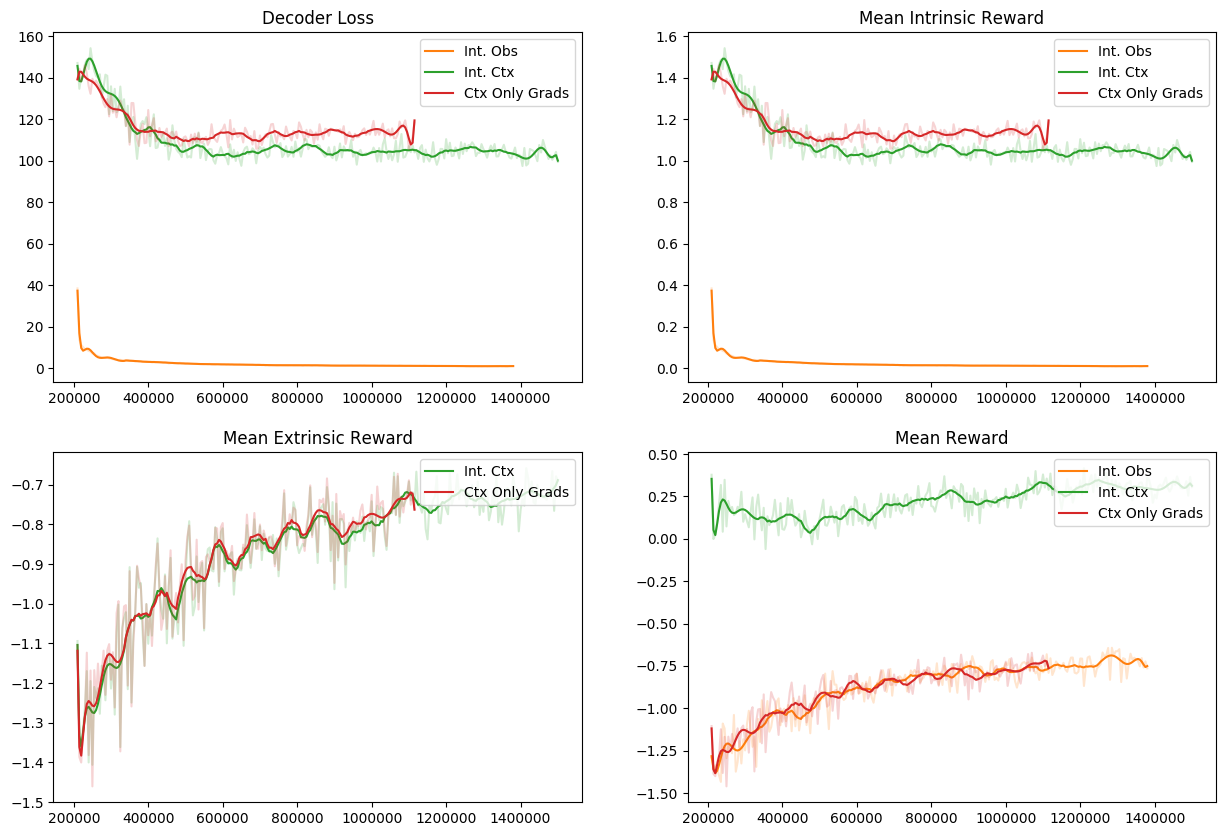

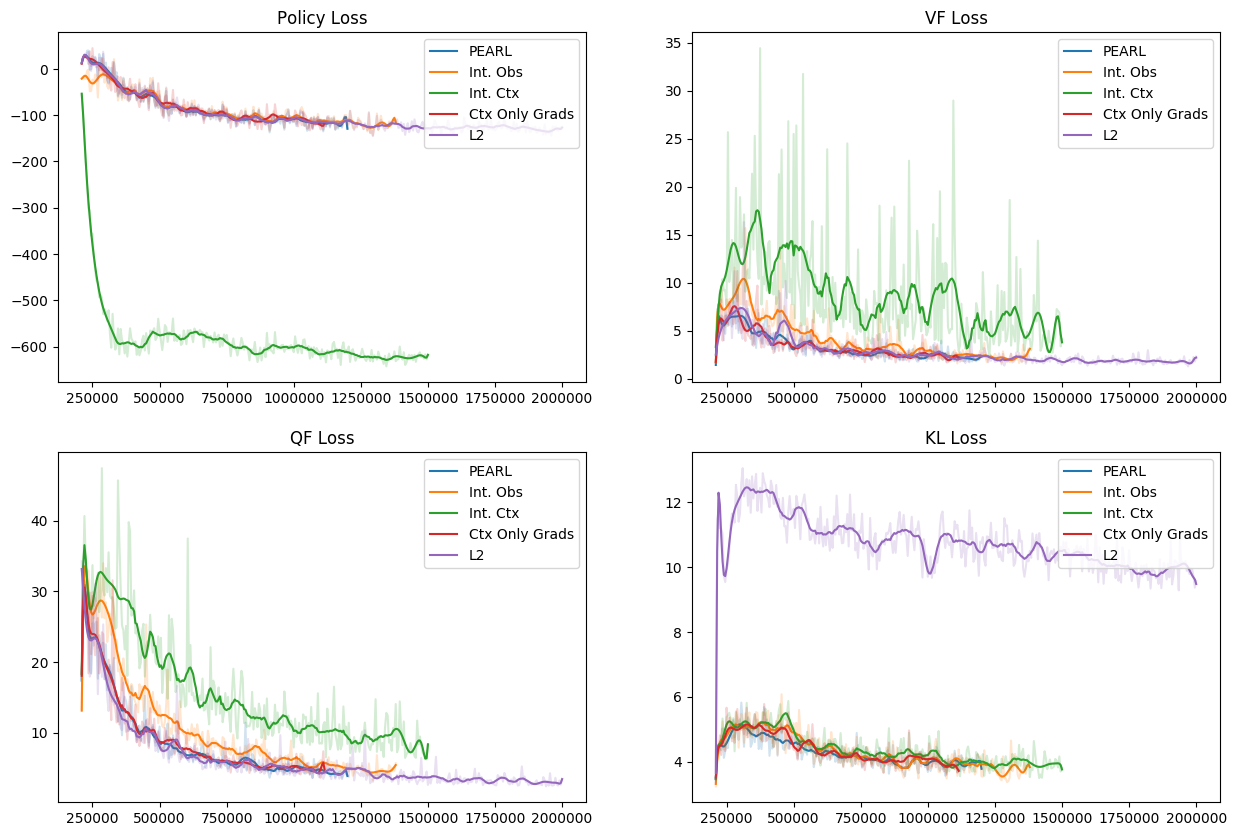

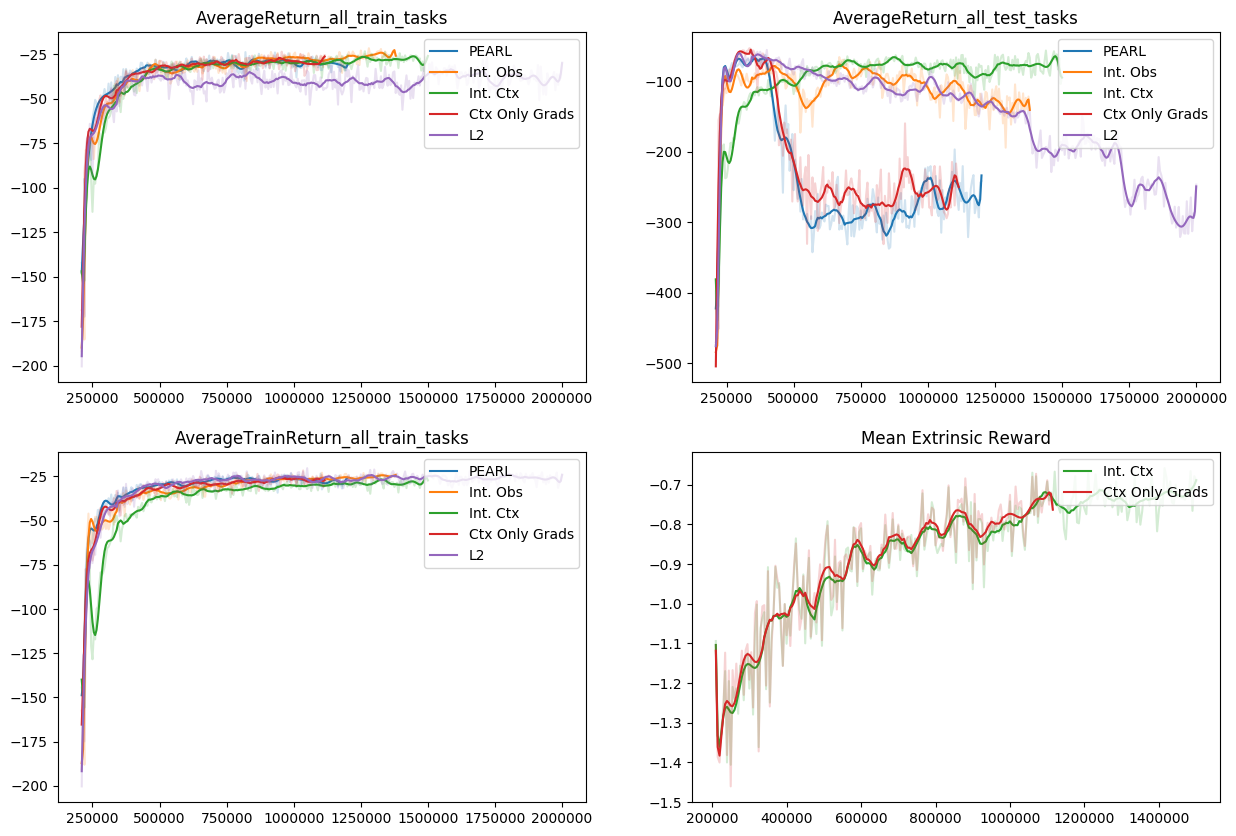

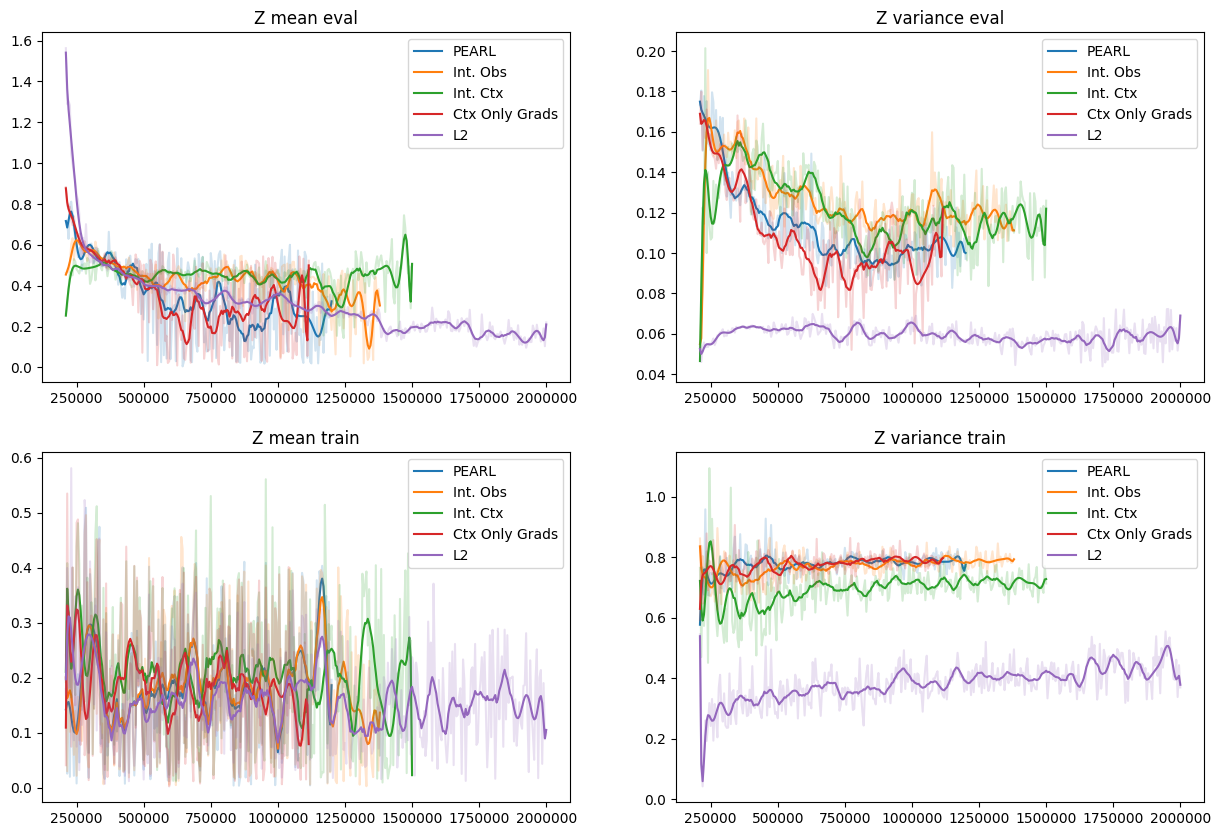

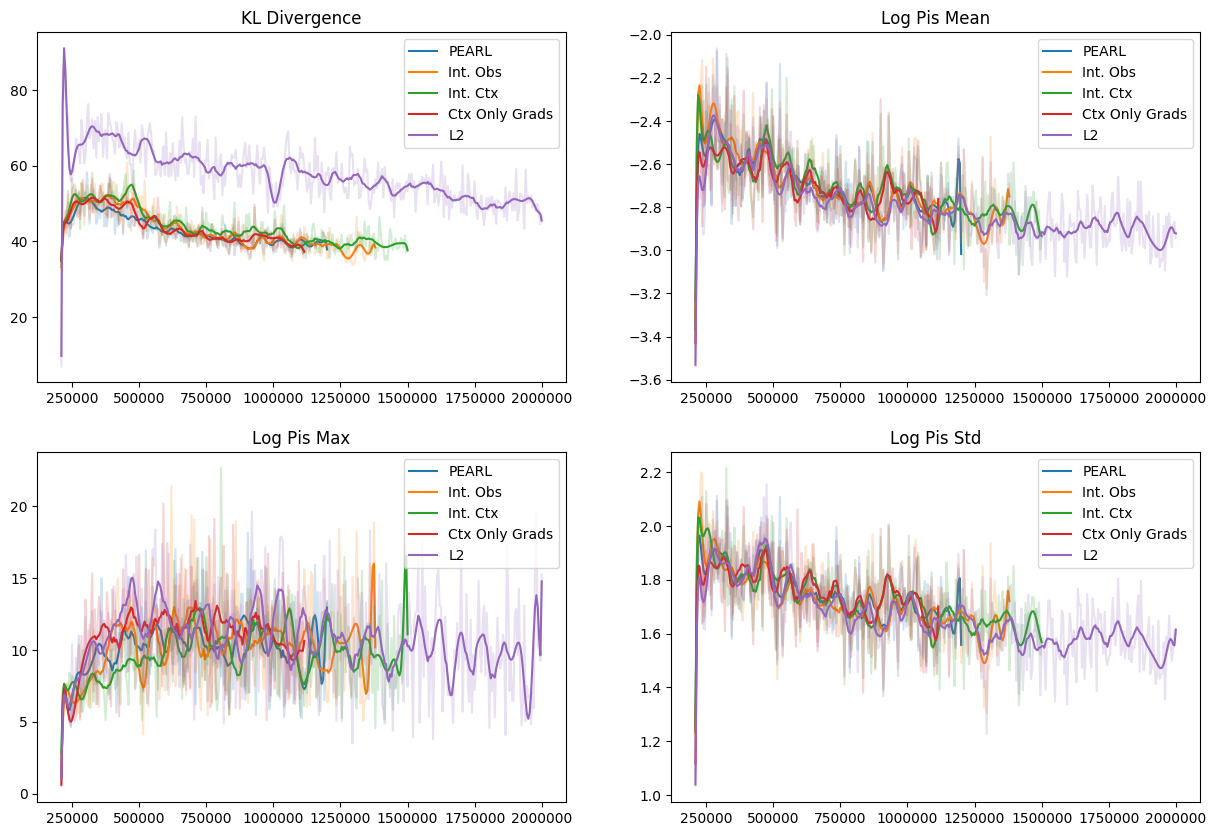

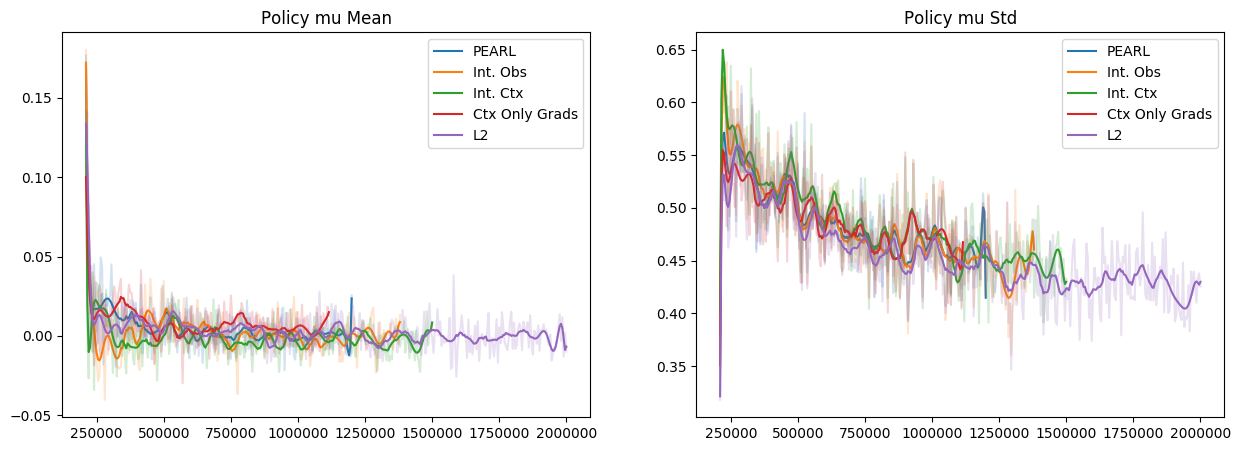

In [277]:
dfs = [df for _, df in results]
labels = [label for label, _ in results]
#plott(dfs, ['Total Train Time (s)', 'Train Time (s)', 'Sample Time (s)', 'Epoch Time (s)'], labels, kind='bar', agg=['max', 'mean', 'mean', 'mean'])
plott(dfs, ['Decoder Loss', 'Mean Intrinsic Reward', 'Mean Extrinsic Reward', 'Mean Reward'], labels)
plott(dfs, ['Policy Loss', 'VF Loss', 'QF Loss', 'KL Loss'], labels)
plott(dfs, ['AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks', 'AverageTrainReturn_all_train_tasks', 'Mean Extrinsic Reward'], labels), 
plott(dfs, ['Z mean eval', 'Z variance eval', 'Z mean train', 'Z variance train'], labels)
plott(dfs, ['KL Divergence', 'Log Pis Mean', 'Log Pis Max', 'Log Pis Std'], labels) # 'Latent Entropy'
plott(dfs, ['Policy mu Mean', 'Policy mu Std'], labels)